# Clasificador de sanitarios cerámicos usando Redes Convolucionales y Keras

## Dataset

Vamos a implementar una red convolucional para clasificar 5 tipos de sanitarios, los cuales corresponden a cierta referencia: referenciaA, referenciaB, referenciaC, referenciaD y referenciaE. Esto con el fin de facilitar el etiquetado de cada sanitario a la hora de su producción. 
El Dataset a emplear consta de 42 imágenes que se encuentran el directorio: ImagenesExamenCeramicos

<div style="text-align:center"><img src="public/sanitarios.png" /></div>

Antes de empezar con la implementación, debido a que las imágenes del dataset son pocas y desbalanceadas, se lleva a cabo un aumento de imágenes (data augmentation). Esto con el objetivo de tener un número de imágenes adecuado para cada clase y distribuirlas para el entrenamiento, validación y pruebas de la red.

El aumento de imágenes se hace de 4 maneras: desplazamiento horizontal, desplazamiento vertical, rotación y cambios de iluminación. Este procedimiento se hace varias veces por cada una de las imágenes existentes en el dataset original. Esto se puede ver en el archivo DataAugmentation.py. 

Después del aumento de datos se verifica manualmente que las imágenes correspondientes a cada clase estén balanceadas. Seguido esto se unen las imágenes generadas con las originales y este será el dataset empleado para el entrenamiento y test. Estas imágenes se encuentran en el directorio: AllImages.

A partir de aquí se realiza un preprocesamiento en las imágenes que consiste en: reducir el tamaño de las imágenes, transformar de rgb a escala de grises, binarizar (ver archivo loadData.py) y normalizar las imágenes. finalmente se lleva acabo el proceso de etiquetado. 

# Implementación.

## Importamos librerías 

Las principales librerías son Numpy, matplotlib para visualizar las imágenes y keras para la construcción del modelo, el entranamiento y predicción 

In [1]:
import os
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.optimizers import SGD

## Cargamos el dataset

Estas 398 imágenes son el conjunto de imágenes reales, mezcladas con las imágenes generadas con dataAugmentation (ver DataAugmentation.py y loadData.py )

In [2]:
from loadData import loadData
dirname = os.path.join(os.getcwd(), 'AllImages')
imgpath = dirname + os.sep 
images, dircount, directories = loadData(imgpath)

leyendo imagenes de  /home/jjat02/Documentos/JJAT/projects/computerVision/clasificadorSanitarios1.0/AllImages/
Directorios leidos: 5
Imagenes en cada directorio [89, 74, 78, 78, 79]
suma Total de imagenes en subdirs: 398


Miramos un ejemplo de una imágen del dataset:

Text(0.5, 1.0, 'imágen ejemplo')

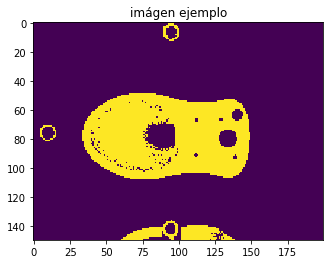

In [3]:
nImagen = 50
plt.imshow(images[nImagen])
plt.title('imágen ejemplo')

## Etiquetamos las imágenes con su respectiva clase

Aquí cada imagen es etiquetada con su clase, las etiquetas son: 
0 -> ReferenciaC, 1 -> ReferenciaB, 2 -> ReferenciaE, 3 -> ReferenciaA, 4 -> ReferenciaD

In [4]:
from loadData import tagImages
X, y, nClasses, refSanitary = tagImages(images, dircount, directories)

Cantidad etiquetas creadas:  398
0 ReferenciaC
1 ReferenciaB
2 ReferenciaE
3 ReferenciaA
4 ReferenciaD
Número total de salidas :  5
Clases :  [0 1 2 3 4]


## Creamos datos de entrenamiento, prueba y validación 

Primero distribuimos el total de imágenes 80% entrenamiento y 20% de test. Se normalizan las imágenes y por último del 80% de datos de entrenamiento se obtiene otro 20% para validación. Obteniendo así: 254 de imágenes para entrenamiento, 80 imágenes de test y 64 imágenes de validación. 

In [5]:
trainX, testX, trainY, testY = train_test_split(X , y, test_size = 0.2)
print('Shape de datos de entrenamiento : ', trainX.shape, trainY.shape)
print('Shape de datos de test : ', testX.shape, testY.shape)

# normalizamos
trainX = trainX / 255.0
testX = testX / 255.0

# cambiamos la etiqueta de categoría a  one-hot encoding
trainY_oneHot = to_categorical(trainY)
testY_oneHot = to_categorical(testY)

trainX, validX, trainLabel, validLabel = train_test_split(trainX, trainY_oneHot, test_size=0.2, random_state=13)
print(trainX.shape, validX.shape, trainLabel.shape, validLabel.shape)

Shape de datos de entrenamiento :  (318, 150, 200) (318,)
Shape de datos de test :  (80, 150, 200) (80,)
(254, 150, 200) (64, 150, 200) (254, 5) (64, 5)


Mostramos un ejemplo de imágen del dataset de entrenamiento

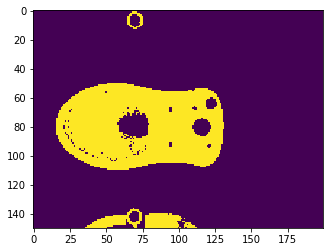

In [6]:
nImagen = 25
plt.imshow(trainX[nImagen])

Reajustamos las imágenes para ser empleadas en la librería de Keras

In [7]:
trainX = trainX.reshape(254, 150, 200, 1)
testX = testX.reshape(80, 150, 200, 1)
validX = validX.reshape(64, 150, 200, 1)
print(trainX.shape)
print(testX.shape)
print(validX.shape)

(254, 150, 200, 1)
(80, 150, 200, 1)
(64, 150, 200, 1)


## Creamos el modelo

Ahora procedemos a crear el modelo de la red, la arquitectura de este modelo se basa en la red convolucional LaNet-5

In [8]:
model = Sequential()
# conv1 y maxpooling1
model.add(Conv2D(filters = 6, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(150, 200,1)))
model.add(MaxPooling2D((2, 2)))

# conv2 y maxpooling2
model.add(Conv2D(filters = 16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# aplanamos el volumen y creamos la salida
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))

model.add(Dense(nClasses, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 200, 6)       156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 100, 6)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 96, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 48, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 26880)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               3225720   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

## Compilamos el modelo 

En esta etapa definimos el optimizador a usar (gradiente descendente, tasa de aprendizaje = 0.1), así como la función de error (entropía cruzada) y la métrica de desempeño (precisión):

In [9]:
sgd = SGD(lr=0.1)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

## Entrenamos el modelo 

Realicemos el entrenamiento usando 15 iteraciones, una tasa de aprendizaje de 0.1 y un tamaño de lote (batch_size) de 16:

In [12]:
epochs = 15
batch_size = 16
train = model.fit(trainX, trainLabel, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (validX, validLabel))
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
model.save("sanitaryModel.h5py")

Epoch 1/15
16/16 [==============================] - 4s 281ms/step - loss: 0.1045 - accuracy: 0.9488 - val_loss: 0.3898 - val_accuracy: 0.8906
Epoch 2/15
16/16 [==============================] - 4s 261ms/step - loss: 0.1051 - accuracy: 0.9488 - val_loss: 0.4074 - val_accuracy: 0.8906
Epoch 3/15
16/16 [==============================] - 4s 281ms/step - loss: 0.1034 - accuracy: 0.9488 - val_loss: 0.4335 - val_accuracy: 0.8906
Epoch 4/15
16/16 [==============================] - 4s 262ms/step - loss: 0.1069 - accuracy: 0.9528 - val_loss: 0.3987 - val_accuracy: 0.8594
Epoch 5/15
16/16 [==============================] - 4s 267ms/step - loss: 0.1032 - accuracy: 0.9488 - val_loss: 0.4061 - val_accuracy: 0.8594
Epoch 6/15
16/16 [==============================] - 4s 260ms/step - loss: 0.1024 - accuracy: 0.9488 - val_loss: 0.4463 - val_accuracy: 0.8281
Epoch 7/15
16/16 [==============================] - 4s 267ms/step - loss: 0.1047 - accuracy: 0.9449 - val_loss: 0.3868 - val_accuracy: 0.8906
Epoch 

## Pérdida y precisión del modelo

In [13]:
testEval = model.evaluate(testX, testY_oneHot, verbose=1)

print('Test loss:', testEval[0])
print('Test accuracy:', testEval[1])

3/3 [==============================] - 0s 94ms/step - loss: 0.6442 - accuracy: 0.8500
Test loss: 0.6441824436187744
Test accuracy: 0.8500000238418579


Observamos que la precisión alcanzada por la red es del 85%, lo cual indica un buen porcentaje ya que los datos de entrenamiento presentan algunas modificaciones con respecto a los datos reales. Esto debido a que la mayoría de imágenes fueron creadas artificialmente. 

## Desempeño del modelo

Para observar con más detalle el desempeño del modelo, graficamos la matriz de confusión, algunas imágenes etiquetadas correctamente y otras incorrectas. 

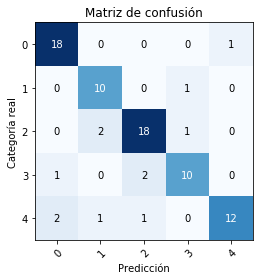

In [15]:
from confusionMatrix import plotConfusionMatrix

predY = model.predict_classes(testX)
labels = ['0','1','2','3','4']
plotConfusionMatrix(testY, predY, labels)

### Predicciones correctas

Se encontraron 68 etiquetas correctas


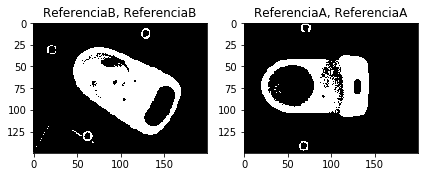

In [28]:
predictedClasses2 = model.predict(testX)
predictedClasses=[]
for sanitaryPredicted in predictedClasses2:
    predictedClasses.append(sanitaryPredicted.tolist().index(max(sanitaryPredicted)))
predictedClasses=np.array(predictedClasses)

correct = np.where(predictedClasses==testY)[0]
print("Se encontraron %d etiquetas correctas" % len(correct))

for i, correct in enumerate(correct[0:2]):
    plt.subplot(1,2,i+1)
    plt.imshow(testX[correct].reshape(150,200), cmap='gray')
    plt.title("{}, {}".format(refSanitary[predictedClasses[correct]], refSanitary[testY[correct]]))
    plt.tight_layout()

plt.show()

### Predicciones incorrectas

Se encontraron 12 etiquetas incorrectas 


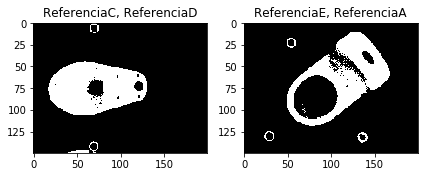

In [27]:
incorrect = np.where(predictedClasses!=testY)[0]
print("Se encontraron %d etiquetas incorrectas " % len(incorrect))
for i, incorrect in enumerate(incorrect[2:4]):
    plt.subplot(1,2,i+1)
    plt.imshow(testX[incorrect].reshape(150,200), cmap='gray')
    plt.title("{}, {}".format(refSanitary[predictedClasses[incorrect]],
                                                    refSanitary[testY[incorrect]]))
    plt.tight_layout()

plt.show()

## Pruebas con imágenes reales

En el anterior test se observó el desempeño de la red con todas las imágenes, es decir con las imágenes reales e imágenes generadas. Ahora observemos el desempeño de la red solo con imágenes reales. 

Cargamos las imágenes originales y las etiquetamos

In [31]:
from loadData import loadData, tagImages
import numpy as np 

directoryName = os.path.join(os.getcwd(), 'ImagenesExamenCeramicos')
imagePath = directoryName + os.sep
# cargamos las imágenes
imagesTest, dircountTest, directoriesTest = loadData(imagePath)
# etiquetamos las imágenes
testImages, testLabel, nClasses, ref = tagImages(imagesTest, dircountTest, directoriesTest)
# conviertimos de lista a numpy y normalizamos
testImages = np.array(testImages, dtype=np.uint8) 
testImages = testImages / 255.0
# redimencionamos
testImages = testImages.reshape(42, 150, 200, 1)

leyendo imagenes de  /home/jjat02/Documentos/JJAT/projects/computerVision/clasificadorSanitarios1.0/ImagenesExamenCeramicos/
Directorios leidos: 5
Imagenes en cada directorio [11, 4, 9, 9, 9]
suma Total de imagenes en subdirs: 42
Cantidad etiquetas creadas:  42
0 ReferenciaC
1 ReferenciaB
2 ReferenciaE
3 ReferenciaA
4 ReferenciaD
Número total de salidas :  5
Clases :  [0 1 2 3 4]


Realizamos la predicción con el modelo guardado previamente y graficamos la matríz de confusión 

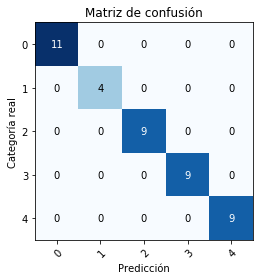

In [32]:
from keras.models import load_model

sanitaryModel = load_model('sanitaryModel.h5py')
predictedClasses = sanitaryModel.predict_classes(testImages)
labels = ['0','1','2','3','4']
plotConfusionMatrix(testLabel, predictedClasses, labels)

## Pérdida y precisión del modelo con imágenes de prueba reales

In [34]:
testLabel_oneHot = to_categorical(testLabel)

test = sanitaryModel.evaluate(testImages, testLabel_oneHot, verbose=1)

print('Test loss:', test[0])
print('Test accuracy:', test[1])

2/2 [==============================] - 0s 35ms/step - loss: 0.0021 - accuracy: 1.0000
Test loss: 0.0020660036243498325
Test accuracy: 1.0


De la matriz de confusión y de la precisión se puede obsercar que todas las imágenes fueron etiquetadas correctamente, es decir se obtuvo una precisión del 100%. 

Se encontraron 42 etiquetas correctas


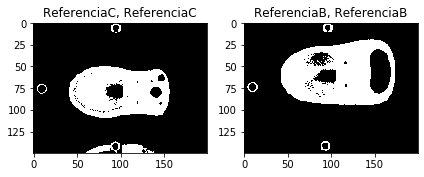

In [42]:
predictClasses2 = sanitaryModel.predict(testImages)
predictClasses=[]
for sanitaryPredicted in predictClasses2:
    predictClasses.append(sanitaryPredicted.tolist().index(max(sanitaryPredicted)))
predictClasses=np.array(predictClasses)

correctPredict = np.where(predictClasses==testLabel)[0]
print("Se encontraron %d etiquetas correctas" % len(correctPredict))

for i, correctPredict in enumerate(correctPredict[10:12]):
    plt.subplot(1,2,i+1)
    plt.imshow(testImages[correctPredict].reshape(150,200), cmap='gray')
    plt.title("{}, {}".format(ref[predictClasses[correctPredict]], ref[testLabel[correctPredict]]))
    plt.tight_layout()

plt.show()